# **Performance of Gradient Boosting Algorithms on a Image Dataset**

# This Notebook contains the comparative analysis of 3 Boosting Algorithms -
XGBoost, CatBoost and LightGBM trained and tested on a Image Dataset

In [0]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

     |████████████████████████████████| 64.8MB 48kB/s 


In [0]:
from keras.datasets import cifar10
from sklearn import metrics
import catboost as ctb
from sklearn.model_selection import cross_val_score    

import time
start_time = time.time()
import numpy as np
import pandas as pd
#import sys
import os
from datetime import datetime
import matplotlib as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import lightgbm as lgb

Using TensorFlow backend.


In [0]:
# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


# **Preprocess the data**

In [0]:
 # X_train is 50000 rows of 3x32x32 values --> reshaped in 50000 x 3072
RESHAPED = 3072

X_train = X_train.reshape(50000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.flatten()
y_test = y_test.flatten()

In [0]:
  # normalize the datasets
X_train /= 255.
X_test /= 255.

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [0]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, pred, average="macro"):
    lb = preprocessing.LabelBinarizer() 
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    pred = lb.transform(pred)
    return roc_auc_score(y_test, pred, average=average)

# **Fit CatBoost model to the data**

In [0]:
from sklearn.metrics import roc_auc_score
model = ctb.CatBoostClassifier(iterations=5, 
                 learning_rate=0.01, depth=6,loss_function='MultiClass')
t1=datetime.now()
model.fit(X_train,y_train)
t2=datetime.now()
execution_time_cat_boost = t2-t1
t3 = datetime.now()
pred = model.predict(X_test)
#pred = model.predict_proba(X_test)[:,1]
t4 = datetime.now()
accuracy_cat_boost= multiclass_roc_auc_score(y_test, pred, average="macro")
#accuracy_cat_boost = round(roc_auc_score(y_test,pred,multi_class="ovr",average=None),5)
#roc_auc_score(y_score=np_pred, y_true=np_label, multi_class="ovr",average=None)
print("Accuracy score = ",accuracy_cat_boost*100,"%")
print("Execution time = ",execution_time_cat_boost)
print("Prediction time = ",t4-t3)
cat_boost_train_time = t2-t1

0:	learn: 2.2973493	total: 14.8s	remaining: 59.2s
1:	learn: 2.2920784	total: 29.3s	remaining: 44s
2:	learn: 2.2871066	total: 43.8s	remaining: 29.2s
3:	learn: 2.2821027	total: 58.4s	remaining: 14.6s
4:	learn: 2.2772999	total: 1m 13s	remaining: 0us
Accuracy score =  61.016666666666666 %
Execution time =  0:01:31.826846
Prediction time =  0:00:01.676078


# **Fit LightGBM model to the data**

In [0]:
params = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
params['metric'] = ['auc', 'binary_logloss']

train_data=lgb.Dataset(X_train,label=y_train)

num_round=50
t1=datetime.now()
lgbm=lgb.train(params,train_data,num_round)
t2=datetime.now()
execution_time_lgbm = t2-t1
t3 = datetime.now()
ypred2=lgbm.predict(X_test)
t4 = datetime.now()

for i in range(0,len(ypred2)): 
    if ypred2[i] >=0.5:
        ypred2[i] = 1
    else:
        ypred2[i] = 0
accuracy_lgbm = round(accuracy_score(ypred2,y_test),5)
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

Accuracy score =  12.53 %
Execution time =  0:01:53.639699
Prediction time =  0:00:00.154363


# **Fit XGBoost model to the data**

In [0]:
from xgboost import XGBClassifier
model = XGBClassifier()
t1=datetime.now()
model.fit(X_train,y_train)
t2=datetime.now()
execution_time_xgb = t2-t1
t3 = datetime.now()
y_pred = model.predict(X_test)
t4 = datetime.now()
predictions = [round(value) for value in y_pred]
accuracy_xgb = round(accuracy_score(y_pred,y_test),5)
print("Accuracy score = ",accuracy_xgb*100,"%")
print("Execution time = ",execution_time_xgb)
print("Prediction time = ",t4-t3)
xgb_train_time = t2-t1

Accuracy score =  44.769999999999996 %
Execution time =  0:49:39.473394
Prediction time =  0:00:01.531145


# **Results and Plots**

# **1.Accuracy Plot**

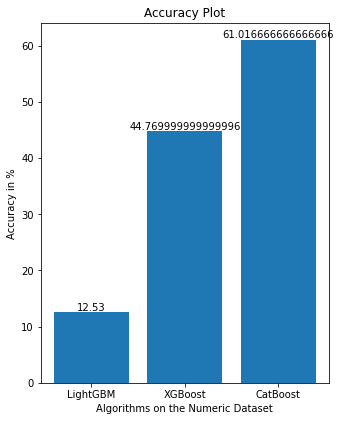

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (4,5))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

# **2.Training Time Plot**

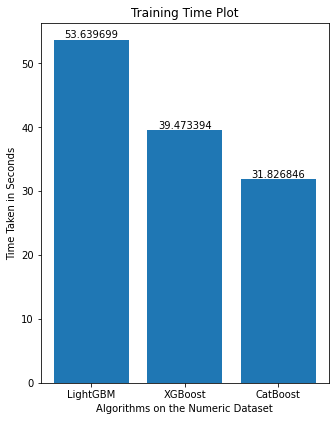

In [0]:
lg = float(str(lgbm_train_time)[5:])
cb = float(str(cat_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (4,5))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
training_time = [lg,xgb,cb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()